# Projet 08: deploiement en local 

#### Objectif: 
   1- Développer une chaîne de traitement composée du preprocessing et une réduction de dimension.
   2-Tenir compte de la variable volume de données qui "va augmenter très rapidement". Par conséquent nous devrons développer
     les scripts en pyspark pour effectuer du calcul distribué (calcul en parallèle)
NB: dans une première étape nous avons installé Spark sur Windows 10. Lien pour infos:https://www.youtube.com/watch?v=Rv4NOAn2m-g mais aussi https://www.youtube.com/watch?v=Rv4NOAn2m-g
Par la suite à l'aide de la commande "pip" nous avons installé les packages utiles pour notre projet et que nous trouvons dans la librairie par la suite.


### Definition des Paths afin de charger les images et enregistrer les résultats

In [1]:
# usefull packages
import pandas as pd
import numpy as np
import io
import os
# deal with image
from PIL import Image

In [2]:
PATH = os.getcwd()
PATH1 = PATH+'/train'
PATH2 = PATH+'/output'
print('PATH:        '+\
      PATH+'\nPATH1:   '+\
      PATH1+'\nPATH2: '+PATH2)

PATH:        C:\Users\mehan\Desktop\DATA SCIENTIST\P08
PATH1:   C:\Users\mehan\Desktop\DATA SCIENTIST\P08/train
PATH2: C:\Users\mehan\Desktop\DATA SCIENTIST\P08/output


### SparkSession

In [304]:
# !pip install findspark

In [ ]:
# !pip install pyarrow

In [3]:
# spark
import findspark
findspark.init()
import pyspark
pyspark.__version__

'3.3.0'

In [4]:
# Import Libraries
# context & session
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession



In [5]:
# data handling
from pyspark.sql.functions import element_at, split
from pyspark.sql.functions import pandas_udf, PandasUDFType
# from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.functions import input_file_name
from pyspark.sql.types import *
from typing import Iterator

In [6]:
# ml tasks
from pyspark.ml.image import ImageSchema
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA

In [7]:
# transform
from pyspark.ml.linalg import Vectors, VectorUDT

In [ ]:
# !pip install tensorflow

In [8]:
# Initiate a Spark session
spark = (SparkSession
             .builder
             .appName('Project8')
         .config("spark.memory.offHeap.enabled","true") 
 .config("spark.memory.offHeap.size","10g")
             .master('local')
             .getOrCreate())

In [9]:
sc = spark.sparkContext

In [10]:
# open spark UI for app monitoring
spark

### Chargement images et traitement

Dans la suite nous allons :

1- Préparer nos données
Importer les images dans un dataframe pandas UDF
Associer aux images leur label
Préprocesser en redimensionnant nos images pour
qu'elles soient compatibles avec notre modèle
2- Préparer notre modèle
Importer le modèle Resnet50
Créer un nouveau modèle dépourvu de la dernière couche de Resnet50
Définir le processus de chargement des images et l'application
de leur featurisation à travers l'utilisation de pandas UDF
Exécuter les actions d'extraction de features
Enregistrer le résultat de nos actions
Tester le bon fonctionnement en chargeant les données enregistrées

#### 1- chargement des images test

In [11]:
# lien https://spark.apache.org/docs/latest/sql-data-sources-generic-options.html
images = spark.read.format("binaryFile") \
              .option("pathGlobFilter", "*.jpg") \
              .option("recursiveFileLookup", "true") \
              .load(PATH1)

In [12]:
# nbre images
images.count()

81

In [13]:
images.show(5)

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|file:/C:/Users/me...|2021-09-12 19:25:46|  5213|[FF D8 FF E0 00 1...|
|file:/C:/Users/me...|2021-09-12 19:25:46|  5207|[FF D8 FF E0 00 1...|
|file:/C:/Users/me...|2021-09-12 19:25:46|  5160|[FF D8 FF E0 00 1...|
|file:/C:/Users/me...|2021-09-12 19:25:46|  5124|[FF D8 FF E0 00 1...|
|file:/C:/Users/me...|2021-09-12 19:25:46|  5104|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows



In [14]:
print(images.printSchema())

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)

None


In [15]:
# nous conservons le path + on ajoute label et observons ce que cela donne pour les 5 premières images

In [16]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+----------------------------------------------------------------------------+-----------+
|path                                                                        |label      |
+----------------------------------------------------------------------------+-----------+
|file:/C:/Users/mehan/Desktop/DATA SCIENTIST/P08/train/Apple Red 1/2_100.jpg |Apple Red 1|
|file:/C:/Users/mehan/Desktop/DATA SCIENTIST/P08/train/Apple Red 1/0_100.jpg |Apple Red 1|
|file:/C:/Users/mehan/Desktop/DATA SCIENTIST/P08/train/Apple Red 1/1_100.jpg |Apple Red 1|
|file:/C:/Users/mehan/Desktop/DATA SCIENTIST/P08/train/Apple Red 1/12_100.jpg|Apple Red 1|
|file:/C:/Users/mehan/Desktop/DATA SCIENTIST/P08/train/Apple Red 1/15_100.jpg|Apple Red 1|
+-------------------------------------------------------------

#### 2-Transfer learning model 

Nous allons utiliser la technique du transfert learning pour extraire les features des images.
Cela consiste à extraire les features les plus pertinentes pour la classification de nos iamges en utilisant un modèle de deep learning pré-entraîné sur de la classification d'image, auquel on enlève la dernière couche - celle qui classifie - afin d'obtenir en sortie un tenseur des features les plus significatives de nos images.
Ce tenseur pourra ensuite être fourni à un autre modèle de classification, qui sera ainsi adapté à nos classes.
Nous utilisons ici un modèle Resnet50 pré-entraîné pour de la classification d'images, auquel nous retirons la dernière couche. 


In [17]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf,col
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
model = ResNet50(weights='imagenet',
                    include_top=False,
                    input_shape=(224, 224, 3))

In [20]:
from keras.models import Model
new_model = Model(inputs=model.input,outputs=model.layers[-2].output)

In [22]:
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [23]:
# Broadcasting model weights to all nodes (https://sparkbyexamples.com/spark/spark-broadcast-variables/)
brodcast_weights = sc.broadcast(new_model.get_weights())

In [24]:
# définition sous forme de fonction 

In [25]:
def model_fn():
    
    model = ResNet50(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

In [26]:
#definition du processus chargement images + featurization

In [27]:
def preprocess(content):
   
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    
    return preprocess_input(arr)

In [28]:
def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)

    # We flatten the feature tensors to vectors 
    output = [p.flatten() for p in preds]
    
    return pd.Series(output)

In [29]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
   
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

C:\Spark\spark-3.3.0-bin-hadoop2\python\pyspark\sql\pandas\functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


#### Exécution des actions d'extractions de features

In [30]:
features_df = images.select(col("path"),col("label"),featurize_udf("content").alias("features"))

In [32]:
features_df.printSchema()
features_df.show()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)

+--------------------+-----------+--------------------+
|                path|      label|            features|
+--------------------+-----------+--------------------+
|file:/C:/Users/me...|Apple Red 1|[0.33400306, 0.41...|
|file:/C:/Users/me...|Apple Red 1|[0.2746902, 0.420...|
|file:/C:/Users/me...|Apple Red 1|[0.6033561, 0.486...|
|file:/C:/Users/me...|Apple Red 1|[0.79373777, 1.09...|
|file:/C:/Users/me...|Apple Red 1|[0.53373295, 1.23...|
|file:/C:/Users/me...|Apple Red 1|[0.8701279, 1.082...|
|file:/C:/Users/me...|Apple Red 1|[0.53375, 1.00151...|
|file:/C:/Users/me...|Apple Red 1|[1.0597596, 0.870...|
|file:/C:/Users/me...|Apple Red 1|[0.6928632, 0.835...|
|file:/C:/Users/me...|Apple Red 1|[0.7655392, 0.913...|
|file:/C:/Users/me...|Apple Red 1|[0.3296679, 0.996...|
|file:/C:/Users/me...|Apple Red 1|[0.8391834, 0.928

In [ ]:
#Postprocessing of features using Vectors.dense and pandas udf

In [33]:
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
features_df = features_df.select(col("path"),  col("label"), list_to_vector_udf(features_df["features"]).alias("features"))

In [ ]:
#Preprocessing

In [35]:
from pyspark.ml.feature import StringIndexer, StandardScaler

In [37]:
standardizer = StandardScaler(withMean=True, withStd=True,
                              inputCol='features',
                              outputCol='features_scaled')
std = standardizer.fit(features_df)
sdf_ = std.transform(features_df)
sdf_ = sdf_.select('path', 'label', 'features_scaled')

In [38]:
sdf_.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features_scaled: vector (nullable = true)



In [39]:
sdf_.show()

+--------------------+-----------+--------------------+
|                path|      label|     features_scaled|
+--------------------+-----------+--------------------+
|file:/C:/Users/me...|Apple Red 1|[-0.9669412620924...|
|file:/C:/Users/me...|Apple Red 1|[-1.1364226230305...|
|file:/C:/Users/me...|Apple Red 1|[-0.1972880870421...|
|file:/C:/Users/me...|Apple Red 1|[0.34671106928474...|
|file:/C:/Users/me...|Apple Red 1|[-0.3962303051997...|
|file:/C:/Users/me...|Apple Red 1|[0.56498933545411...|
|file:/C:/Users/me...|Apple Red 1|[-0.3961815950701...|
|file:/C:/Users/me...|Apple Red 1|[1.10684558670584...|
|file:/C:/Users/me...|Apple Red 1|[0.05847075044033...|
|file:/C:/Users/me...|Apple Red 1|[0.26613616937192...|
|file:/C:/Users/me...|Apple Red 1|[-0.9793286227603...|
|file:/C:/Users/me...|Apple Red 1|[0.47656801710140...|
|file:/C:/Users/me...|Apple Red 1|[0.93842196793662...|
|file:/C:/Users/me...|Apple Red 1|[0.81694520620453...|
|file:/C:/Users/me...|Apple Red 1|[1.33923241833

### PCA fit tansform

In [40]:
dim_pca = 200
pca = PCA(k=dim_pca,
          inputCol='features_scaled', 
          outputCol='features_pca',
         )

pca_model = pca.fit(sdf_)
pca_sdf = pca_model.transform(sdf_)

pca_sdf = pca_sdf.select('path', 'label', 'features_pca')

In [41]:
pca_sdf.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features_pca: vector (nullable = true)



In [42]:
pca_sdf.show()

+--------------------+-----------+--------------------+
|                path|      label|        features_pca|
+--------------------+-----------+--------------------+
|file:/C:/Users/me...|Apple Red 1|[-16.595507731027...|
|file:/C:/Users/me...|Apple Red 1|[-16.322717738834...|
|file:/C:/Users/me...|Apple Red 1|[-16.841716509679...|
|file:/C:/Users/me...|Apple Red 1|[-18.593006348902...|
|file:/C:/Users/me...|Apple Red 1|[-18.738653913564...|
|file:/C:/Users/me...|Apple Red 1|[-19.220201498294...|
|file:/C:/Users/me...|Apple Red 1|[-18.146904329876...|
|file:/C:/Users/me...|Apple Red 1|[-18.491714969956...|
|file:/C:/Users/me...|Apple Red 1|[-18.091163908861...|
|file:/C:/Users/me...|Apple Red 1|[-18.114929101042...|
|file:/C:/Users/me...|Apple Red 1|[-19.000036788587...|
|file:/C:/Users/me...|Apple Red 1|[-18.264990881929...|
|file:/C:/Users/me...|Apple Red 1|[-18.412661908933...|
|file:/C:/Users/me...|Apple Red 1|[-18.459314004639...|
|file:/C:/Users/me...|Apple Red 1|[-17.724146236

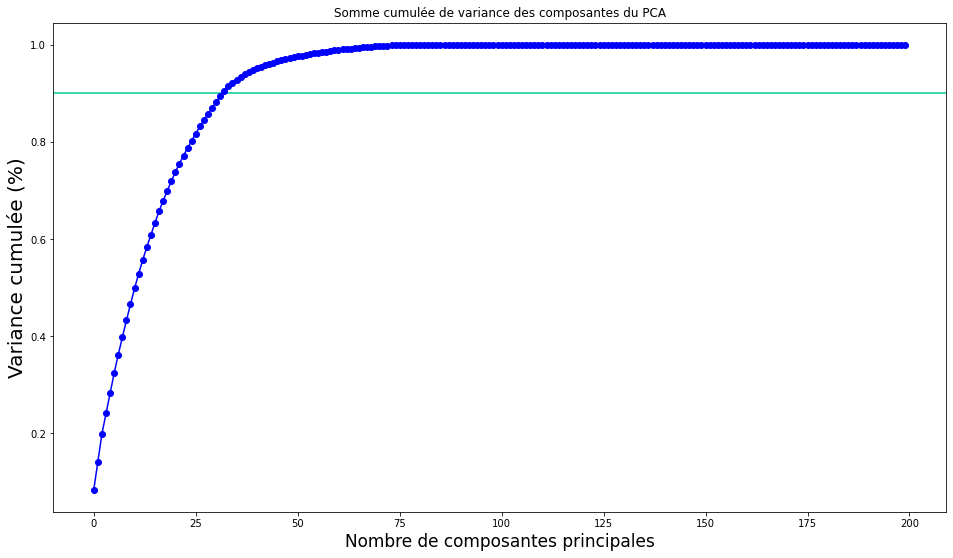

In [57]:
plt.figure(figsize=(16, 9))
plt.title('Somme cumulée de variance des composantes du PCA')
plt.ylabel("Variance cumulée (%)",  size=20)
plt.xlabel('Nombre de composantes principales', size=17)
plt.axhline(y=0.9, color='#02CA91', linestyle='-')

plt.plot(pca_model.explainedVariance.cumsum(),c="blue",marker='o')

In [44]:
c = 0
for i in pca_model.explainedVariance.cumsum():
    c += 1
    if(i > 0.95):
        print(
            'Il faut {} composantes pour expliquer 95% de la variance du dataset'.format(c))
        break

Il faut 41 composantes pour expliquer 95% de la variance du dataset


In [45]:
pca_sdf_final = pca_sdf.select('path', 'label', 'features_pca')
## Pandas convertion
pca_sdf_pandas = pca_sdf_final.toPandas()
pca_sdf_pandas

,path,label,features_pca
0,file:/C:/Users/mehan/Desktop/DATA SCIENTIST/P0...,Apple Red 1,"[-16.595507731027887, 21.53377863770465, 0.872..."
1,file:/C:/Users/mehan/Desktop/DATA SCIENTIST/P0...,Apple Red 1,"[-16.32271773883454, 21.280698830826648, -0.10..."
2,file:/C:/Users/mehan/Desktop/DATA SCIENTIST/P0...,Apple Red 1,"[-16.841716509679152, 24.10892192212397, 1.819..."
3,file:/C:/Users/mehan/Desktop/DATA SCIENTIST/P0...,Apple Red 1,"[-18.59300634890204, 26.795439289968837, 0.732..."
4,file:/C:/Users/mehan/Desktop/DATA SCIENTIST/P0...,Apple Red 1,"[-18.73865391356451, 25.4538179059828, 1.03708..."
...,...,...,...
76,file:/C:/Users/mehan/Desktop/DATA SCIENTIST/P0...,Banana,"[26.576261698708656, -3.418555632813063, 0.113..."
77,file:/C:/Users/mehan/Desktop/DATA SCIENTIST/P0...,Banana,"[28.453368085769227, -0.33108978735804273, 2.4..."
78,file:/C:/Users/mehan/Desktop/DATA SCIENTIST/P0...,Banana,"[27.51624127939283, -2.717336283528107, -5.966..."
79,file:/C:/Users/mehan/Desktop/DATA SCIENTIST/P0...,Banana,"[28.57315907404543, -3.075770056022345, -1.839..."


### Sauvegarde des résultats Parquet

Le format parquet est privilégie pour son efficacité par rapport aux formats JSON ou CSV.

In [46]:
print(PATH2)

C:\Users\mehan\Desktop\DATA SCIENTIST\P08/output


In [61]:
pca_sdf_final.write.parquet(PATH2)

Py4JJavaError: An error occurred while calling o264.parquet.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.jobAbortedError(QueryExecutionErrors.scala:638)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:278)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:186)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:113)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:111)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:125)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:109)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:94)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:584)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:176)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:584)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:560)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:94)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:81)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:79)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:116)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:860)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:390)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:363)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:239)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:793)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 21.0 failed 1 times, most recent failure: Lost task 0.0 in stage 21.0 (TID 33) (LAPTOP-UJKFRJ5A executor driver): java.lang.UnsatisfiedLinkError: org.apache.hadoop.io.nativeio.NativeIO$Windows.createFileWithMode0(Ljava/lang/String;JJJI)Ljava/io/FileDescriptor;
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.createFileWithMode0(Native Method)
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.createFileOutputStreamWithMode(NativeIO.java:559)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileOutputStream.<init>(RawLocalFileSystem.java:219)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileOutputStream.<init>(RawLocalFileSystem.java:209)
	at org.apache.hadoop.fs.RawLocalFileSystem.createOutputStreamWithMode(RawLocalFileSystem.java:307)
	at org.apache.hadoop.fs.RawLocalFileSystem.create(RawLocalFileSystem.java:296)
	at org.apache.hadoop.fs.RawLocalFileSystem.create(RawLocalFileSystem.java:328)
	at org.apache.hadoop.fs.ChecksumFileSystem$ChecksumFSOutputSummer.<init>(ChecksumFileSystem.java:398)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:461)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:440)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:911)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:892)
	at org.apache.parquet.hadoop.util.HadoopOutputFile.create(HadoopOutputFile.java:74)
	at org.apache.parquet.hadoop.ParquetFileWriter.<init>(ParquetFileWriter.java:329)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:482)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:420)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:409)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetOutputWriter.<init>(ParquetOutputWriter.scala:36)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$$anon$1.newInstance(ParquetFileFormat.scala:155)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.newOutputWriter(FileFormatDataWriter.scala:161)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.<init>(FileFormatDataWriter.scala:146)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:317)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$write$21(FileFormatWriter.scala:256)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:245)
	... 42 more
Caused by: java.lang.UnsatisfiedLinkError: org.apache.hadoop.io.nativeio.NativeIO$Windows.createFileWithMode0(Ljava/lang/String;JJJI)Ljava/io/FileDescriptor;
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.createFileWithMode0(Native Method)
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.createFileOutputStreamWithMode(NativeIO.java:559)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileOutputStream.<init>(RawLocalFileSystem.java:219)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileOutputStream.<init>(RawLocalFileSystem.java:209)
	at org.apache.hadoop.fs.RawLocalFileSystem.createOutputStreamWithMode(RawLocalFileSystem.java:307)
	at org.apache.hadoop.fs.RawLocalFileSystem.create(RawLocalFileSystem.java:296)
	at org.apache.hadoop.fs.RawLocalFileSystem.create(RawLocalFileSystem.java:328)
	at org.apache.hadoop.fs.ChecksumFileSystem$ChecksumFSOutputSummer.<init>(ChecksumFileSystem.java:398)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:461)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:440)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:911)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:892)
	at org.apache.parquet.hadoop.util.HadoopOutputFile.create(HadoopOutputFile.java:74)
	at org.apache.parquet.hadoop.ParquetFileWriter.<init>(ParquetFileWriter.java:329)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:482)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:420)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:409)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetOutputWriter.<init>(ParquetOutputWriter.scala:36)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$$anon$1.newInstance(ParquetFileFormat.scala:155)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.newOutputWriter(FileFormatDataWriter.scala:161)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.<init>(FileFormatDataWriter.scala:146)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:317)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$write$21(FileFormatWriter.scala:256)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more


In [54]:
# Mise en place d'un Dataframe avec pour chaque fruit une séparation en colonne de chaque feature identifié
df_final = pd.DataFrame(np.zeros((pca_sdf_pandas.shape[0], 6)))
for i in range(6):
    df_final.loc[:,i] = pca_sdf_pandas["features_pca"].apply(lambda x : x[i])

df_final_pca = pd.concat([pca_sdf_pandas['label'], df_final], axis=1)

In [55]:
df_final_pca

,label,0,1,2,3,4,5
0,Apple Red 1,-16.595508,21.533779,0.872289,2.580301,1.238060,1.639987
1,Apple Red 1,-16.322718,21.280699,-0.109533,-2.342627,0.681587,-0.125755
2,Apple Red 1,-16.841717,24.108922,1.819527,0.001314,-1.704248,-1.654856
3,Apple Red 1,-18.593006,26.795439,0.732259,-1.190149,2.079720,-0.963016
4,Apple Red 1,-18.738654,25.453818,1.037083,0.346110,2.398302,-0.368866
...,...,...,...,...,...,...,...
76,Banana,26.576262,-3.418556,0.113078,-0.114085,-0.428089,-0.175336
77,Banana,28.453368,-0.331090,2.497331,0.060440,0.085441,-0.283846
78,Banana,27.516241,-2.717336,-5.966653,-0.004628,0.598851,-0.020784
79,Banana,28.573159,-3.075770,-1.839146,-0.117783,-0.333959,0.336074


### Visualisation des différents fruits par projection sur les 2 axes principaux ¶

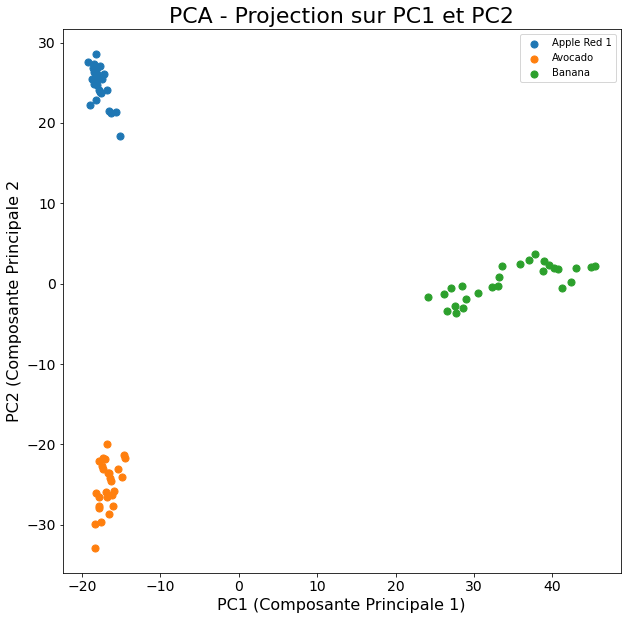

In [56]:
# Visualisation des différents fruits par projection sur les 2 axes principaux d'inertie

plt.figure(figsize=(10,10))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('PC1 (Composante Principale 1)',fontsize=16)
plt.ylabel('PC2 (Composante Principale 2',fontsize=16)

for fruit in df_final_pca.label.unique():
    dfred = df_final_pca[df_final_pca.label==fruit]
    plt.scatter(dfred[0], dfred[1], label=fruit, s=50)
    #dots = ax.collections[-1] 
    #offsets = dots.get_offsets() 
    #jittered_offsets = offsets + np.random.uniform(0, 1, offsets.shape) 
    #dots.set_offsets(jittered_offsets)

plt.title("PCA - Projection sur PC1 et PC2",fontsize=22)

plt.legend()    
plt.show()

Nous allons maintenant généraliser le processus en déployant notre solution
sur un réel cluster de machines en travaillant sur un plus grand nombre d'images